Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
dtype = torch.float32
device = torch.device("cpu") #cuda:0

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/GitHub/master-thesis

/content/drive/MyDrive/GitHub/master-thesis


In [5]:
import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

In [17]:
from model.modeloptimization import bij_transform, bij_transform_inv
from model.modelinitialisierung import initialize_observations

## Optimization Settings

In [7]:
start_time='2020-02-26'
end_time='2022-01-31'
observations=['Confirmed_cases', 'Admissions_hospital'] # ['Number_of_deaths', 'Confirmed_cases', 'Admissions_hospital']

## Initialize Observations

In [10]:
df_obs_initial = pd.read_csv('data/observations_03022022.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs = initialize_observations(df_obs_initial, start=start_time, end=end_time, observations=observations)
df_obs.head(3)

,Date,Confirmed_cases,Admissions_hospital
0,2020-02-26,1,0
1,2020-02-27,1,0
2,2020-02-28,1,0


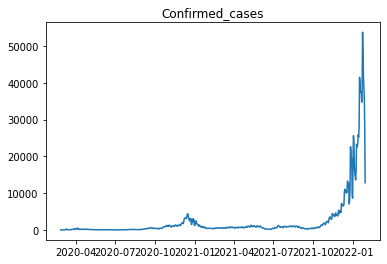

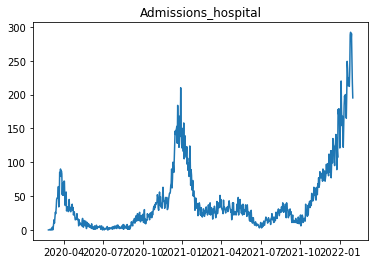

In [11]:
for observation in observations:
  plt.plot(df_obs['Date'], df_obs[observation])
  plt.title(observation)
  plt.show()

## Initialize Model Parameter

### Initialize Helper Parameter

In [39]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize to be optimized Model Parameter

In [36]:
R0_lower, R0_upper = 2, 5
phi_lower, phi_upper = 0, 50
sigma_lower, sigma_upper = 0.00001, 0.5
alpha_lower, alpha_upper = 0.001, 0.05

In [37]:
R0_prime = bij_transform_inv(torch.tensor(3.6, device=device, dtype=dtype), R0_lower, R0_upper).detach().clone().requires_grad_(True)
phi_prime = bij_transform_inv(torch.tensor(25, device=device, dtype=dtype), phi_lower, phi_upper).detach().clone().requires_grad_(True)
sigma_prime = bij_transform_inv(torch.tensor(0.1, device=device, dtype=dtype), sigma_lower, sigma_upper).detach().clone().requires_grad_(True)
alpha_prime = bij_transform_inv(torch.tensor(0.01, device=device, dtype=dtype), alpha_lower, alpha_upper).detach().clone().requires_grad_(True)

sigma = bij_transform(sigma_prime, sigma_lower, sigma_upper)

In [41]:
epsilon_t = torch.zeros(num_observations, device=device, dtype=dtype)
epsilon_t[0] = torch.distributions.Normal(cero, sigma.detach()).rsample()
for t in range(1, num_observations):
    epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma.detach()).rsample()
epsilon_t.requires_grad_(True)

tensor([ 0.0399,  0.1174, -0.0270,  0.1582,  0.2437,  0.1707,  0.0692,  0.1002,
         0.2253,  0.3122,  0.3665,  0.1818,  0.2161,  0.0283,  0.0113,  0.0632,
        -0.2706, -0.1997, -0.0718, -0.0863,  0.0315,  0.0768,  0.0768,  0.2108,
         0.1820,  0.1303,  0.0497,  0.0518,  0.1174, -0.0087,  0.0190,  0.0904,
         0.1035,  0.0922,  0.2067,  0.1025,  0.1092, -0.0323, -0.0046,  0.0328,
        -0.0827, -0.0285,  0.0147,  0.0066,  0.1734,  0.1029,  0.1707,  0.1513,
         0.0045, -0.0599, -0.0348, -0.0180,  0.0320,  0.1028,  0.1739,  0.2278,
         0.2463,  0.3448,  0.4146,  0.5326,  0.9475,  1.0008,  0.9778,  1.1339,
         1.3162,  1.5916,  1.5048,  1.6337,  1.7560,  1.7408,  1.5645,  1.5993,
         1.4323,  1.5056,  1.4473,  1.2936,  1.3209,  1.3110,  1.4098,  1.2232,
         1.0760,  1.0948,  0.9157,  0.8272,  0.7622,  0.7730,  0.7945,  0.8832,
         1.0093,  0.9045,  0.8486,  0.8355,  0.7848,  0.8917,  0.8389,  0.9570,
         0.9700,  0.9876,  0.9354,  0.94

# Optimization

## Loss Functions - To Do (adapt to new setting - maybe put in extra .py file)

In [ ]:
def calc_random_walk_loss(epsilon_t, sigma, training_days):
    loc = epsilon_t[:training_days-1]
    scale = sigma * torch.ones(training_days - 1, device=device)
    mvn = distributions.multivariate_normal.MultivariateNormal(loc, scale_tril=torch.diag(scale))
    ll = mvn.log_prob(epsilon_t[1:training_days])
    return -ll

In [ ]:
def calc_mse(expected, observed, training_days):
    diff = expected - observed[:training_days]
    square = diff.square()
    msr = square.mean()
    return msr

In [ ]:
dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))
dist_R0 = distributions.normal.Normal(loc=torch.tensor([3.6], device=device), scale=torch.tensor([0.8], device=device))
dist_alpha = distributions.normal.Normal(loc=torch.tensor([0.01], device=device), scale=torch.tensor([0.01], device=device))
dist_sigma = distributions.normal.Normal(loc=torch.tensor([0.05], device=device), scale=torch.tensor([0.03], device=device))

def calc_prior_loss(R0, sigma, phi, alpha):
    # log likelihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood

    ll = torch.tensor(0.0, device=device)

    ll += dist_R0.log_prob(R0)[0] # neg

    ll += dist_sigma.log_prob(sigma)[0]

    ll += dist_phi.log_prob(phi)[0]

    ll += dist_alpha.log_prob(alpha)[0]

    return -ll

## Training

# Evaluation